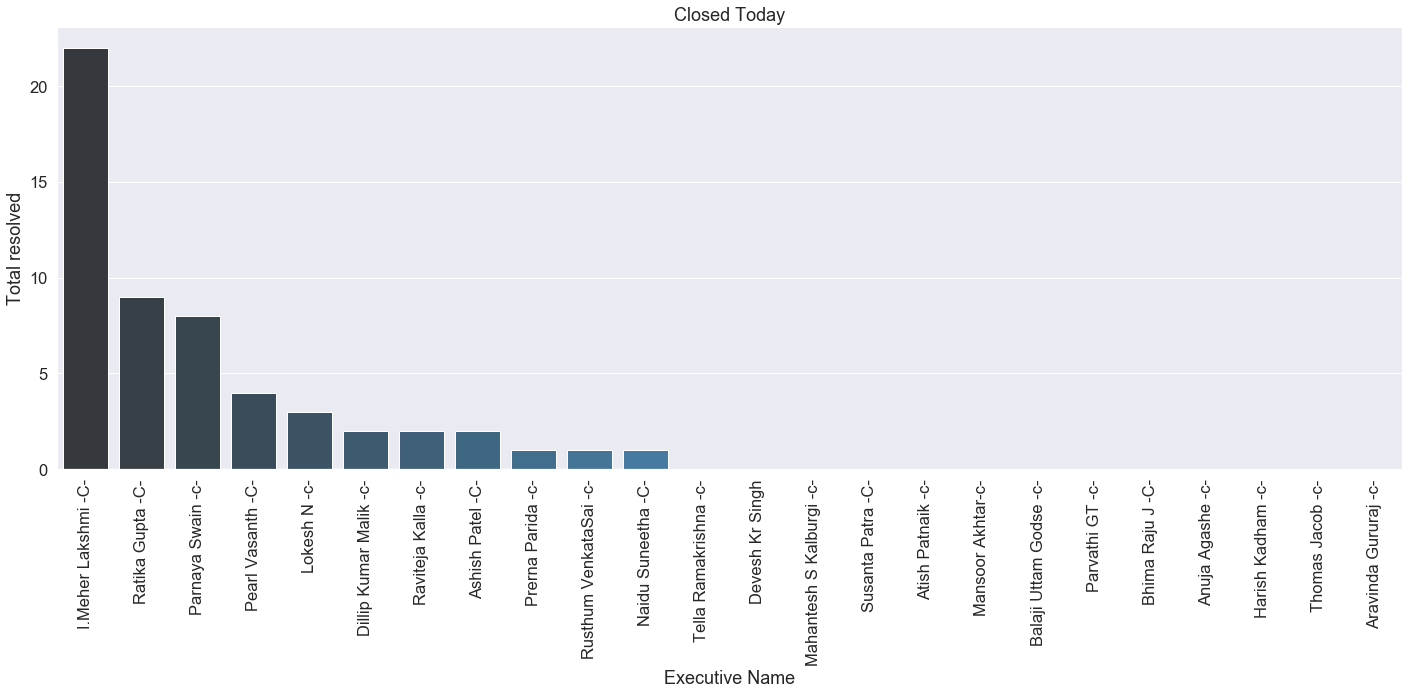

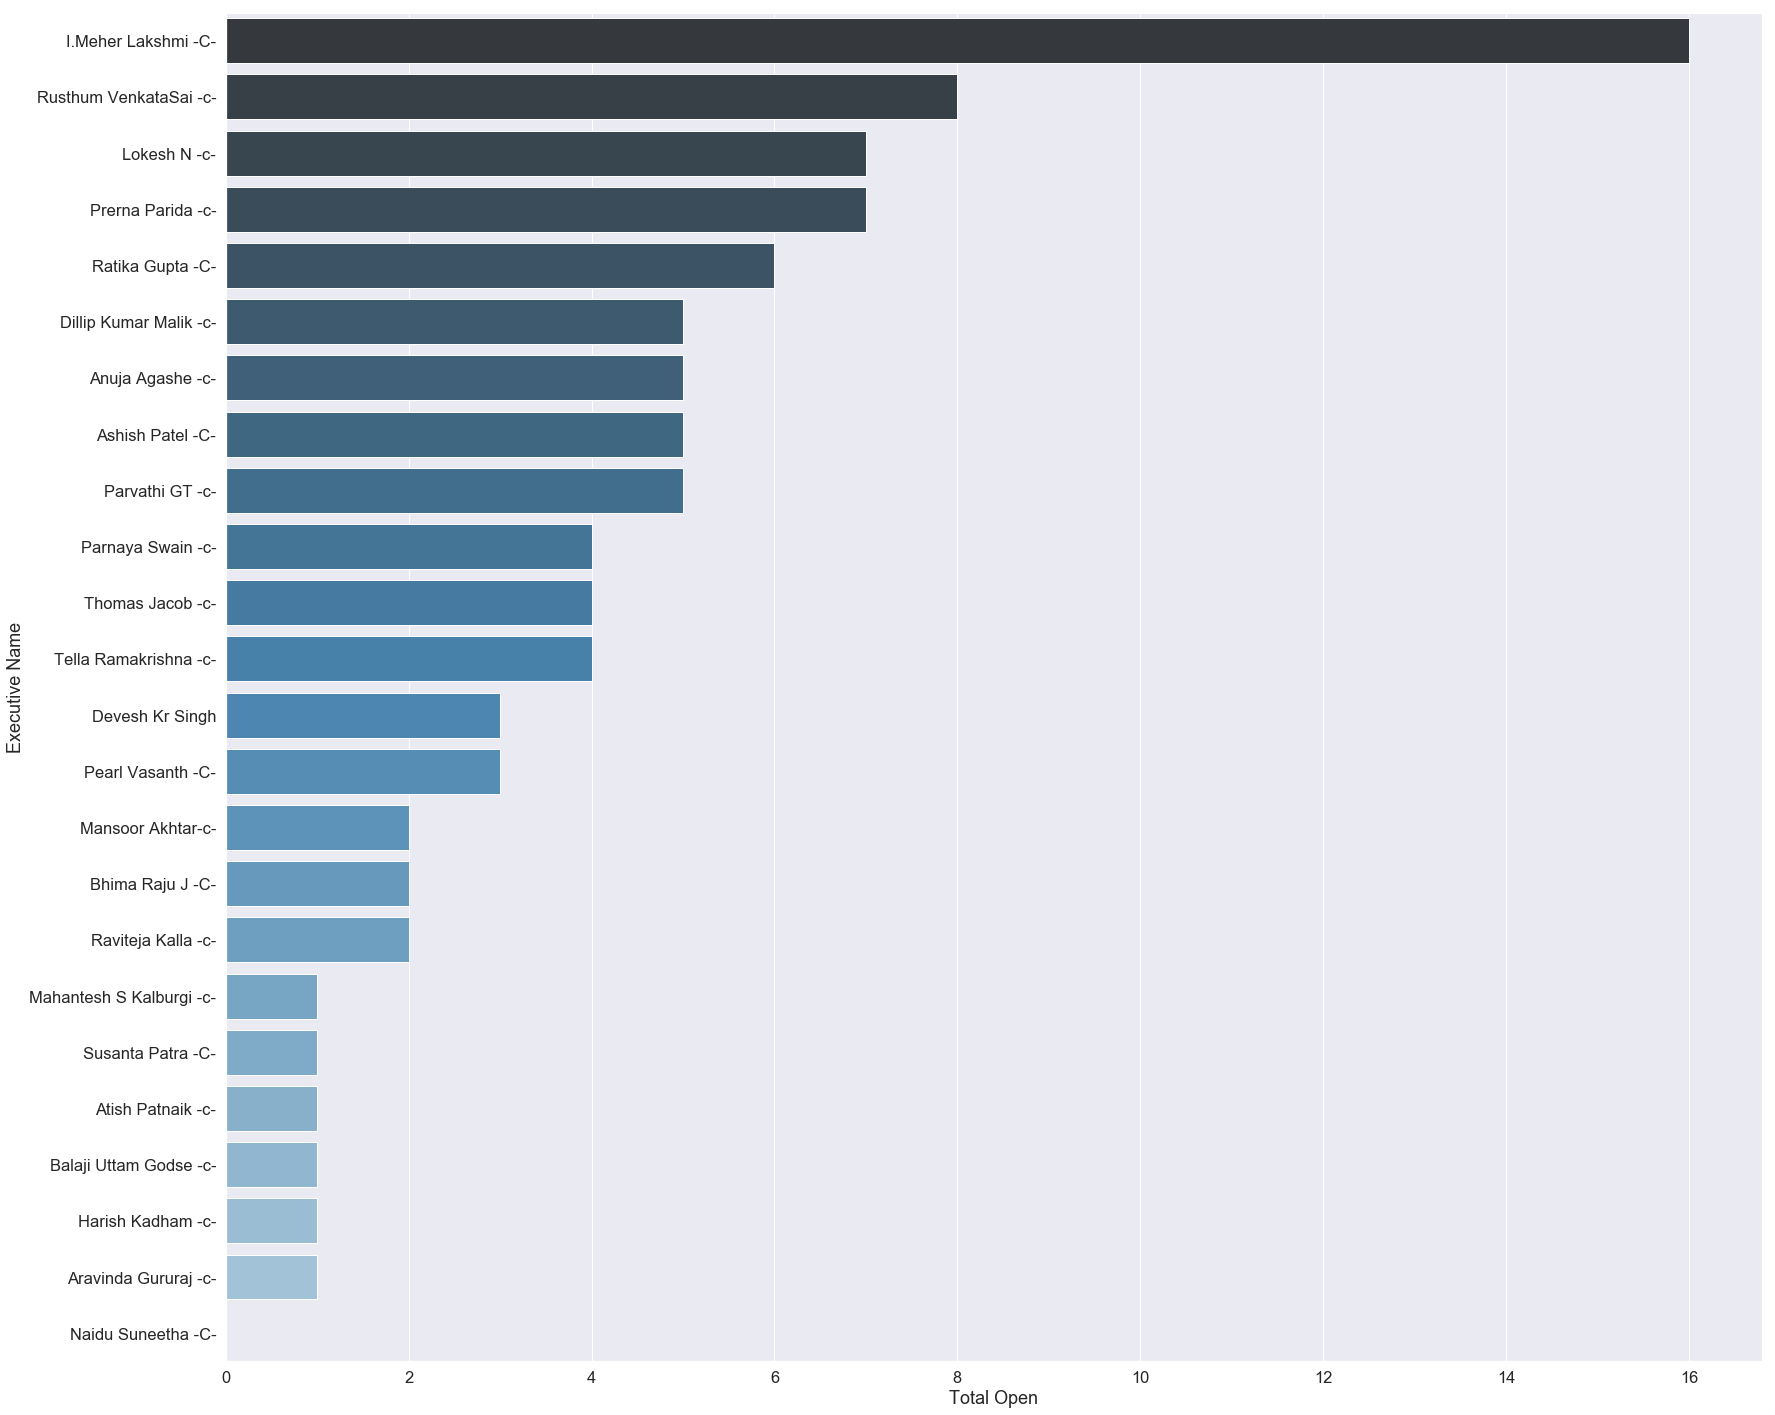

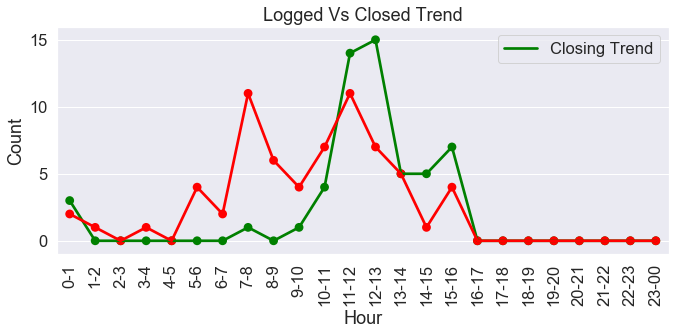

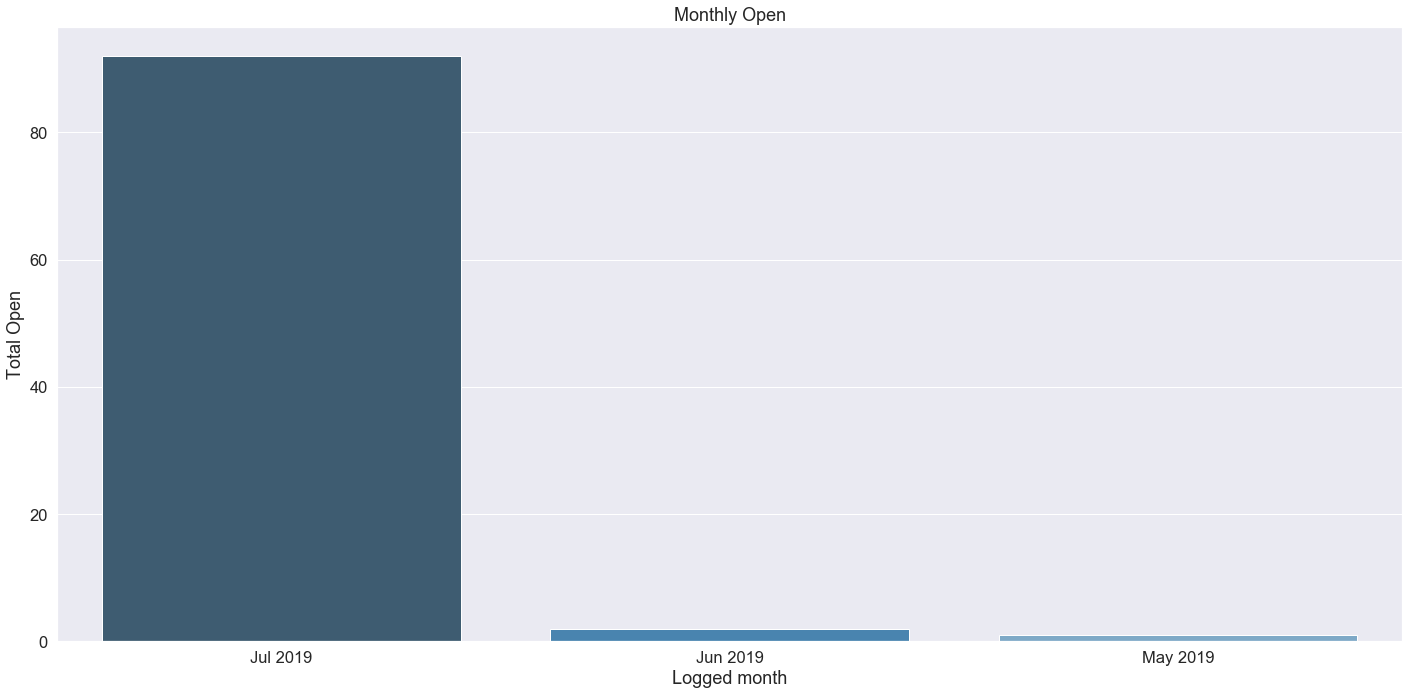

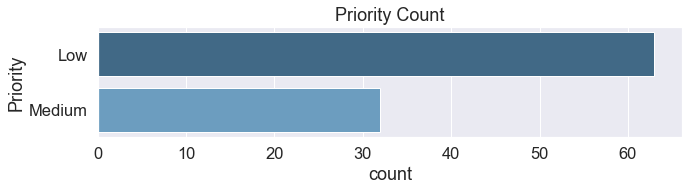

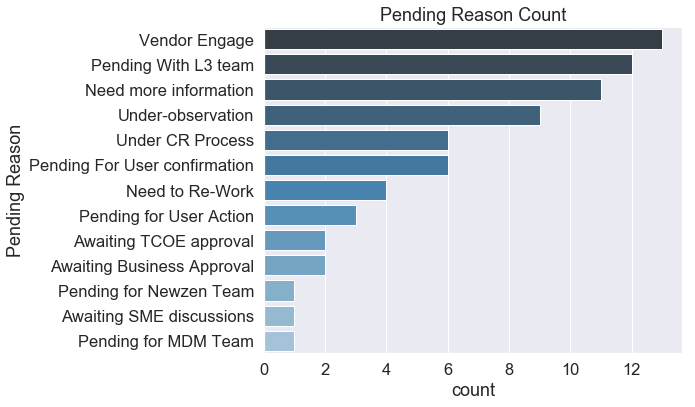

In [13]:
import datetime as dt
import requests
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid", rc = {"figure.figsize": (10, 8)})
sns.set(font_scale=1.5)


#while (dt.datetime.now().hour!=22):

try:
    sURL                        = "https://mobileci.symphonysummit.com/HCCBPL/REST/Summit_RESTWCF.svc/RestService/CommonWS_JsonObjCall"
    sHeaders                    = {'Content-type': 'application/json'}
    sToday= dt.date.today()
    sTodaysDate= str(sToday.year)+"-"+str(sToday.month)+"-"+str(sToday.day)+" 00:00:00"

    sLog = '----------------------------------'+ str(dt.datetime.now()) + '------------------------------------'+'\n'


    sAllOpenData = {"ServiceName":"IM_GetIncidentList",
                "objCommonParameters":{"_ProxyDetails": {
                    "TokenID": "",
                    "OrgID": "1",
                    "ReturnType": "JSON",
                    "Password": "CGAP1@coca",
                    "UserName": "CGAPI@coca-cola.in",
                    "ProxyID": 0
                },"objIncidentCommonFilter":{"Executive":1,"WorkgroupName":"Capgemini Application L1,Capgemini Application L2,Capgemini Application L3,Capgemini Application L4,SFDC-CapG,SF-Cap Gemini,Kronos-CapG","CurrentPageIndex":0,"PageSize":1000,"OrgID":"1","Instance":"HCCBPL","Status":"Pending,In-Progress,Assigned","strUpdatedFromDate":"","strUpdatedToDate":"", "IsWebServiceRequest":"true"}}}

    sOutput = requests.post(url = sURL, json = sAllOpenData, headers = sHeaders)



    sFile = open('AllOpen.json', "w",encoding="utf-8")
    sFile.write(sOutput.text) 
    sFile.close()

    sLog = sLog + str(dt.datetime.now()) + ': All Open Data Fetched'+'\n'

    jsonDump=pd.read_json('AllOpen.json')
    jsonTicket=jsonDump['OutputObject']['MyTickets']
    allDf = pd.DataFrame.from_dict(jsonTicket, orient='columns')

    startDate= str(sToday.year)+"-"+str(sToday.month)+"-"+str((sToday.replace(day = 1)).day)+" 00:00:00"
    endDate=str(sToday.year)+"-"+str(sToday.month)+"-"+str((sToday.replace(day = calendar.monthrange(sToday.year, sToday.month)[1])).day)+" 00:00:00"

    # JSON Data to fetch All Capgemini Scope current month Incidents across all the tracks - L1/L2/L3/L4/SFDC/SF/KRONOS
    sMonthData = {"ServiceName":"IM_GetIncidentList",
            "objCommonParameters":{"_ProxyDetails": {
                "TokenID": "",
                "OrgID": "1",
                "ReturnType": "JSON",
                "Password": "CGAP1@coca",
                "UserName": "CGAPI@coca-cola.in",
                "ProxyID": 0
            },"objIncidentCommonFilter":{"Executive":1,"WorkgroupName":"Capgemini Application L1,Capgemini Application L2,Capgemini Application L3,Capgemini Application L4,SFDC-CapG,SF-Cap Gemini,Kronos-CapG","CurrentPageIndex":0,"PageSize":1000,"OrgID":"1","Instance":"HCCBPL","Status":"Resolved","strUpdatedFromDate":""+sTodaysDate+"","strUpdatedToDate":"", "IsWebServiceRequest":"true"}}}

    sOutput = requests.post(url = sURL, json = sMonthData, headers = sHeaders) 


    sFile = open('MonthData.json', "w",encoding="utf-8")
    sFile.write(sOutput.text) 
    sFile.close()

    sLog = sLog + str(dt.datetime.now()) + ': Current Month Data Fetched'+'\n'

    jsonDump=pd.read_json('MonthData.json')
    jsonTicket=jsonDump['OutputObject']['MyTickets']
    monthDf = pd.DataFrame.from_dict(jsonTicket, orient='columns')

    incidentDf=monthDf.append(allDf) #appending dataframes

    #Extracting required columns
    incidentDf=incidentDf[['Incident ID','Logged Time','Status','Workgroup Name','Executive Name','Priority','Updated_Time','FullCategory','AgingInfo','Pending Reason']]

    incidentDf.drop_duplicates(subset='Incident ID',inplace = True) #Removing duplicates

    #Datetime Conversion
    incidentDf['Logged Time']=pd.to_datetime(incidentDf['Logged Time'])
    incidentDf['Updated_Time']=pd.to_datetime(incidentDf['Updated_Time'])

    #Changing Workgroup names
    groups={"Capgemini Application L1": "L1/L2","Capgemini Application L2":"L1/L2","Capgemini Application L3":"L3/L4","Capgemini Application L4":"L3/L4","Kronos-CapG":"Kronos","SFDC-CapG":"SFDC","SF-Cap Gemini":"SF"}
    incidentDf=incidentDf.replace({'Workgroup Name':groups})

    #Derived Columns
    incidentDf['Logged date']=[x.date() for x in incidentDf['Logged Time']]
    incidentDf['Logged month']=[x.strftime('%b %Y') for x in incidentDf['Logged Time']]
    incidentDf['Updated_On']=[x.date() for x in incidentDf['Updated_Time']]

    #Function to assign the categories w.r.t their area
    def area(row):    
        if row['Workgroup Name']=='Kronos':
            return 'Kronos'
        elif row['Workgroup Name']=='SFDC':
            return 'SFDC'
        elif row['Workgroup Name']=='SF':
            return 'SF'
        elif 'DMS' in row['FullCategory'].upper():
            return 'DMS'
        elif 'TMS' in row['FullCategory'].upper():
            return 'TMS'
        elif 'RGM' in row['FullCategory'].upper():
            return 'RGM'
        elif 'transport management system' in row['FullCategory'].lower():
            return 'TMS'
        else:
            return 'Legacy Non-RGM'


    incidentDf['FullCategory']=incidentDf['FullCategory'].replace({None:'other'}) #Replacing null values as others category
    incidentDf['Area']=incidentDf.apply(area,axis=1) #Calling function to assign the area


    OpenDf=incidentDf[(incidentDf['Status']=='Assigned') | (incidentDf['Status']=='In-Progress') | (incidentDf['Status']=='Pending')]
    ClosedDf=incidentDf[((incidentDf['Status']=='Resolved') | (incidentDf['Status']=='Closed')) & (incidentDf['Updated_On']==dt.datetime.today().date())]
    TodayDf=OpenDf.append(ClosedDf) #appending dataframes
    CHDf=TodayDf[(TodayDf['Priority']=='Critical') | (TodayDf['Priority']=='High') ]
    MDf=TodayDf[(TodayDf['Priority']=='Medium')]
    PendingDf=incidentDf[(incidentDf['Status']=='Pending')] #Pending Dataframe

    sLog = sLog + str(dt.datetime.now()) + ': Dataframes created successfully'+'\n'

    #Functions for background colors in HTML

    def bgcolorRed(value):
            if value!=0:
                return """<td align="center" style="width: 100px;background-color:red;color:white">"""+str(value)+"""</td>"""
            else:
                return """<td align="center" style="width: 100px;background-color:#ECF6FF"> </td>"""

    def bgcolorGreen(value):
        if value!=0:
            return """<td align="center" style="width: 100px;background-color:#2EB914;color:white">"""+str(value)+"""</td>"""
        else:
            return """<td align="center" style="width: 100px;background-color:#ECF6FF"> </td>"""

    def bgcolorNope(value):
        if value!=0:
            return """<td align="center" style="width: 100px;background-color:#ECF6FF">"""+str(value)+"""</td>"""
        else:
            return """<td align="center" style="width: 100px;background-color:#ECF6FF"> </td>"""

    def bgcolorAmber(value):
        if value!=0:
            return """<td align="center" style="width: 100px;background-color:#E3872B;color:white">"""+str(value)+"""</td>"""
        else:
            return """<td align="center" style="width: 100px;background-color:#ECF6FF"> </td>"""


    def fontcolorRed(value):
        if value!=0:
            return """<td align="center" style="width: 100px;color:red;background-color:#ECF6FF">"""+str(value)+"""</td>"""
        else:
            return """<td align="center" style="width: 100px;background-color:#ECF6FF"> </td>"""

    def bgcolor(value):
        if value!=0:
            return """<td align="center" style="width: 100px">"""+str(value)+"""</td>"""
        else:
            return """<td align="center" style="width: 100px"> </td>"""

    def TodayLoggedCount(Area,Workgroup):
        return len(incidentDf[((incidentDf['Logged date']==dt.datetime.today().date()) & (incidentDf['Area']==Area) & (incidentDf['Workgroup Name']==Workgroup)  )])

    def TodayClosedCount(Area,Workgroup):
        return len(incidentDf[((incidentDf['Logged date']==dt.datetime.today().date()) & (incidentDf['Area']==Area) & (incidentDf['Workgroup Name']==Workgroup) &  ((incidentDf['Status']=='Resolved') | (incidentDf['Status']=='Closed')))])

    def TodayOpenCount(Area,Workgroup):
        return len(incidentDf[((incidentDf['Logged date']==dt.datetime.today().date()) & (incidentDf['Area']==Area) & (incidentDf['Workgroup Name']==Workgroup) & ((incidentDf['Status']=='In-Progress') | (incidentDf['Status']=='Pending') | (incidentDf['Status']=='Assigned')))])

    def TodayStatusCount(Area,Workgroup,Status):
        return len(incidentDf[((incidentDf['Logged date']==dt.datetime.today().date()) & (incidentDf['Area']==Area) & (incidentDf['Workgroup Name']==Workgroup) &  ((incidentDf['Status']==Status)) )])



    def CHLoggedCount(Area,Workgroup):
        return len(CHDf[(CHDf['Area']==Area) & (CHDf['Workgroup Name']==Workgroup)])

    def CHClosedCount(Area,Workgroup):
        return len(CHDf[(CHDf['Area']==Area) & (CHDf['Workgroup Name']==Workgroup) & ( (CHDf['Status']=='Resolved') | (CHDf['Status']=='Closed') )])

    def CHOpenCount(Area,Workgroup):
        return len(CHDf[(CHDf['Area']==Area) & (CHDf['Workgroup Name']==Workgroup) & ((CHDf['Status']=='In-Progress') | (CHDf['Status']=='Pending') | (CHDf['Status']=='Assigned'))])


    def MLoggedCount(Area,Workgroup):
        return len(MDf[(MDf['Area']==Area) & (MDf['Workgroup Name']==Workgroup)])

    def MClosedCount(Area,Workgroup):
        return len(MDf[(MDf['Area']==Area) & (MDf['Workgroup Name']==Workgroup) & ( (MDf['Status']=='Resolved') | (MDf['Status']=='Closed') )])

    def MOpenCount(Area,Workgroup):
        return len(MDf[(MDf['Area']==Area) & (MDf['Workgroup Name']==Workgroup) & ((MDf['Status']=='In-Progress') | (MDf['Status']=='Pending') | (MDf['Status']=='Assigned'))])

    def TotalOpen(Area,Workgroup):
        return len(OpenDf[(OpenDf['Workgroup Name']==Workgroup) & (OpenDf['Area']==Area)])

    def TotalPending(Area,Workgroup):
        return len(OpenDf[(OpenDf['Workgroup Name']==Workgroup) & (OpenDf['Area']==Area) & (OpenDf['Status']=='Pending')])

    def TotalInPro(Area,Workgroup):
        return len(OpenDf[(OpenDf['Workgroup Name']==Workgroup) & (OpenDf['Area']==Area) & (OpenDf['Status']=='In-Progress')])

    def TotalAssigned(Area,Workgroup):
        return len(OpenDf[(OpenDf['Workgroup Name']==Workgroup) & (OpenDf['Area']==Area) & (OpenDf['Status']=='Assigned')])

    def PendingReasonCount(Area,Workgroup,Reason):
            return len(PendingDf[((PendingDf['Area']==Area) & (PendingDf['Workgroup Name']==Workgroup) & (PendingDf['Pending Reason']==Reason))])

    def monthlycount(Area,Workgroup,Month):
        return len(OpenDf[((OpenDf['Area']==Area) & (OpenDf['Workgroup Name']==Workgroup) & (OpenDf['Logged month']==Month))])

    def MonthLoggedCount(Area,Workgroup):
        return len(incidentDf[((incidentDf['Area']==Area) & (incidentDf['Workgroup Name']==Workgroup)  )])

    sLog = sLog + str(dt.datetime.now()) + ': Declared required functions'+'\n'

    PendingReasons=list(OpenDf['Pending Reason'].unique())
    PendingReasons=list(filter(None, PendingReasons))
    PendingReasonHTML=''
    for i in range(len(PendingReasons)):

        HTML="""<tr style="font-family:Calibri">
        <td style="width: 200px;background-color:#ECF6FF">"""+PendingReasons[i]+"""</td>
        """+bgcolorNope(PendingReasonCount('Legacy Non-RGM','L1/L2',PendingReasons[i]))+"""
        """+bgcolorNope(PendingReasonCount('Legacy Non-RGM','L3/L4',PendingReasons[i]))+"""
        """+bgcolorNope(PendingReasonCount('RGM','L1/L2',PendingReasons[i]))+"""
        """+bgcolorNope(PendingReasonCount('RGM','L3/L4',PendingReasons[i]))+"""
        """+bgcolorNope(PendingReasonCount('SFDC','SFDC',PendingReasons[i]))+"""
        """+bgcolorNope(PendingReasonCount('SF','SF',PendingReasons[i]))+"""
        """+bgcolorNope(PendingReasonCount('Kronos','Kronos',PendingReasons[i]))+"""
        """+bgcolorNope(PendingReasonCount('DMS','L1/L2',PendingReasons[i]))+"""
        """+bgcolorNope(PendingReasonCount('DMS','L3/L4',PendingReasons[i]))+"""
        """+bgcolorNope(PendingReasonCount('TMS','L1/L2',PendingReasons[i]))+"""
        """+bgcolorNope(PendingReasonCount('TMS','L3/L4',PendingReasons[i]))

        PendingReasonHTML=PendingReasonHTML+HTML

    MonthsList=list(OpenDf['Logged month'].unique())
    MonthsList=list(filter(None, MonthsList))
    MonthWiseHTML=''
    for i in range(len(MonthsList)):

        HTML="""<tr style="font-family:Calibri">
        <td style="width: 200px;background-color:#ECF6FF">"""+MonthsList[i]+"""</td>
        """+bgcolorNope(monthlycount('Legacy Non-RGM','L1/L2',MonthsList[i]))+"""
        """+bgcolorNope(monthlycount('Legacy Non-RGM','L3/L4',MonthsList[i]))+"""
        """+bgcolorNope(monthlycount('RGM','L1/L2',MonthsList[i]))+"""
        """+bgcolorNope(monthlycount('RGM','L3/L4',MonthsList[i]))+"""
        """+bgcolorNope(monthlycount('SFDC','SFDC',MonthsList[i]))+"""
        """+bgcolorNope(monthlycount('SF','SF',MonthsList[i]))+"""
        """+bgcolorNope(monthlycount('Kronos','Kronos',MonthsList[i]))+"""
        """+bgcolorNope(monthlycount('DMS','L1/L2',MonthsList[i]))+"""
        """+bgcolorNope(monthlycount('DMS','L3/L4',MonthsList[i]))+"""
        """+bgcolorNope(monthlycount('TMS','L1/L2',MonthsList[i]))+"""
        """+bgcolorNope(monthlycount('TMS','L3/L4',MonthsList[i]))
        MonthWiseHTML=MonthWiseHTML+HTML



    EDf=pd.DataFrame(incidentDf['Executive Name'].unique())
    EDf=EDf[EDf[0] != '']

    #Function to find number of resolved
    def totResolved(row):
        return len(TodayDf[(TodayDf['Status']=='Resolved') & (TodayDf['Executive Name']==row['Executive Name'])])

    EDf.columns=['Executive Name']
    EDf['Total resolved']=EDf.apply(totResolved,axis=1)


    #Function to find number of Open
    def totOpen(row):
        return len(incidentDf[((incidentDf['Status']!='Resolved') & (incidentDf['Status']!='Closed')) & (incidentDf['Executive Name']==row['Executive Name'])])

    EDf['Total Open']=EDf.apply(totOpen,axis=1)

    EDf=EDf.sort_values(['Total resolved'], ascending=False) #Sorting in descending order

    plt.figure(figsize=(20,10))
    plt.title('Closed Today')
    closed=sns.barplot(x='Executive Name',y='Total resolved',data=EDf,palette="Blues_d")
    plt.xticks(rotation=90)
    plt.tight_layout()
    closed.get_figure().savefig("Closed.png")

    EDf=EDf.sort_values(['Total Open'], ascending=False)

    plt.figure(figsize=(25,20))
    openPlot=sns.barplot(y='Executive Name',x='Total Open',data=EDf,palette="Blues_d")
    plt.tight_layout()
    openPlot.get_figure().savefig("Open.png")

    ################################################ Trends ################################################

    TodayDf['LoggedHour']=[x.strftime('%H') for x in TodayDf['Logged Time']]
    TodayDf['UpdatedHour']=[x.strftime('%H') for x in TodayDf['Updated_Time']]

    def LoggedBtwn(row):
        if(row['LoggedHour']=='00'):
            return '0-1'
        elif(row['LoggedHour']=='01'):
            return '1-2'
        elif(row['LoggedHour']=='02'):
            return '2-3'
        elif(row['LoggedHour']=='03'):
            return '3-4'
        elif(row['LoggedHour']=='04'):
            return '4-5'
        elif(row['LoggedHour']=='05'):
            return '5-6'
        elif(row['LoggedHour']=='06'):
            return '6-7'
        elif(row['LoggedHour']=='07'):
            return '7-8'
        elif(row['LoggedHour']=='08'):
            return '8-9'
        elif(row['LoggedHour']=='09'):
            return '9-10'
        elif(row['LoggedHour']=='10'):
            return '10-11'
        elif(row['LoggedHour']=='11'):
            return '11-12'
        elif(row['LoggedHour']=='12'):
            return '12-13'
        elif(row['LoggedHour']=='13'):
            return '13-14'
        elif(row['LoggedHour']=='14'):
            return '14-15'
        elif(row['LoggedHour']=='15'):
            return '15-16'
        elif(row['LoggedHour']=='16'):
            return '16-17'
        elif(row['LoggedHour']=='17'):
            return '17-18'
        elif(row['LoggedHour']=='18'):
            return '18-19'
        elif(row['LoggedHour']=='19'):
            return '19-20'
        elif(row['LoggedHour']=='20'):
            return '20-21'
        elif(row['LoggedHour']=='21'):
            return '21-22'
        elif(row['LoggedHour']=='22'):
            return '22-23'
        else:
            return '23-00'

    def UpdatedBtwn(row):
        if(row['UpdatedHour']=='00'):
            return '0-1'
        elif(row['UpdatedHour']=='01'):
            return '1-2'
        elif(row['UpdatedHour']=='02'):
            return '2-3'
        elif(row['UpdatedHour']=='03'):
            return '3-4'
        elif(row['UpdatedHour']=='04'):
            return '4-5'
        elif(row['UpdatedHour']=='05'):
            return '5-6'
        elif(row['UpdatedHour']=='06'):
            return '6-7'
        elif(row['UpdatedHour']=='07'):
            return '7-8'
        elif(row['UpdatedHour']=='08'):
            return '8-9'
        elif(row['UpdatedHour']=='09'):
            return '9-10'
        elif(row['UpdatedHour']=='10'):
            return '10-11'
        elif(row['UpdatedHour']=='11'):
            return '11-12'
        elif(row['UpdatedHour']=='12'):
            return '12-13'
        elif(row['UpdatedHour']=='13'):
            return '13-14'
        elif(row['UpdatedHour']=='14'):
            return '14-15'
        elif(row['UpdatedHour']=='15'):
            return '15-16'
        elif(row['UpdatedHour']=='16'):
            return '16-17'
        elif(row['UpdatedHour']=='17'):
            return '17-18'
        elif(row['UpdatedHour']=='18'):
            return '18-19'
        elif(row['UpdatedHour']=='19'):
            return '19-20'
        elif(row['UpdatedHour']=='20'):
            return '20-21'
        elif(row['UpdatedHour']=='21'):
            return '21-22'
        elif(row['UpdatedHour']=='22'):
            return '22-23'
        else:
            return '23-00'



    TodayDf['LoggedBtwn']=TodayDf.apply(LoggedBtwn,axis=1)
    TodayDf['UpdatedBtwn']=TodayDf.apply(UpdatedBtwn,axis=1)

    def LoggedHour(row):
            return len(trendDf[(trendDf['LoggedBtwn']==row['Hour']) & (trendDf['Logged date']==dt.datetime.now().date())])

    trendDf=TodayDf[(TodayDf['Logged date']==dt.datetime.now().date())]
    HourDf=pd.DataFrame(['0-1','1-2','2-3','3-4','4-5','5-6','6-7','7-8','8-9','9-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22','22-23','23-00'])
    HourDf.columns=['Hour']
    HourDf['Total Logged']=HourDf.apply(LoggedHour,axis=1)


    def ClosedHour(row):
            return len(TodayDf[(TodayDf['UpdatedBtwn']==row['Hour']) & (TodayDf['Status']=='Resolved')])

    HourDf['Total Closed']=HourDf.apply(ClosedHour,axis=1)

    # plt.figure(figsize=(10,5))
    # trend=sns.pointplot(x='Hour',y='Total Logged',data=HourDf,dodge=True)
    # plt.title('Logging Trend')
    # plt.xticks(rotation=90)
    # plt.tight_layout()
    # trend.get_figure().savefig("LogTrend.png")

    # plt.figure(figsize=(10,5))
    # trend=sns.pointplot(x='Hour',y='Total Closed',data=HourDf,dodge=True)
    # plt.title('Closing Trend')
    # plt.xticks(rotation=90)
    # plt.tight_layout()
    # trend.get_figure().savefig("CloseTrend.png")

    plt.figure(figsize=(10,5))
    trend1=sns.pointplot(x='Hour',y='Total Closed',data=HourDf,dodge=True,color='green')
    trend=sns.pointplot(x='Hour',y='Total Logged',data=HourDf,dodge=True,color='red')
    plt.ylabel('Count')
    plt.title('Logged Vs Closed Trend')
    plt.xticks(rotation=90)
    plt.legend(labels=["Closing Trend"])
    plt.tight_layout()
    trend.get_figure().savefig("LogCloseTrend.png")


    #Function to find number of open per month
    def monthlyOpen(row):
        return len(OpenDf[(OpenDf['Logged month']==row['Logged month'])])

    Months=pd.DataFrame(OpenDf['Logged month'].unique())
    Months.columns=['Logged month']
    Months['Total Open']=Months.apply(monthlyOpen,axis=1)
    Months=Months.sort_values(['Total Open'], ascending=False)
    plt.figure(figsize=(20,10))
    plt.title('Monthly Open')
    monthlyopen=sns.barplot(x='Logged month',y='Total Open',data=Months,palette="Blues_d")
    #plt.xticks(rotation=90)
    plt.tight_layout()
    monthlyopen.get_figure().savefig("MonthlyOpen.png")



    #Priority Count
    plt.figure(figsize=(10,3))
    plt.title('Priority Count')
    openPlot=sns.countplot(y='Priority',data=OpenDf,palette="Blues_d",order = OpenDf['Priority'].value_counts().index)
    plt.tight_layout()
    openPlot.get_figure().savefig("Priority.png")

    #Pending Count
    plt.figure(figsize=(10,6))
    plt.title('Pending Reason Count')
    openPlot=sns.countplot(y='Pending Reason',data=incidentDf,palette="Blues_d",order = incidentDf['Pending Reason'].value_counts().index)
    plt.tight_layout()
    openPlot.get_figure().savefig("Pending.png")

    incidentDf=incidentDf[incidentDf['Logged month']==sToday.strftime('%b %Y')]
    incidentDf['Logged day']=[x.day for x in incidentDf['Logged Time']]


    def totMLogged(row):
        return len(MonthData[(MonthData['Logged date']==row['Day'])])

    #Function to find number of resolved
    def totMResolved(row):
        return len(MonthData[((MonthData['Status']=='Resolved') | (MonthData['Status']=='Closed'))  & (MonthData['Updated_On']==row['Day'])])


    # MonthData=pd.read_excel('MonthData.xlsx')
    # mTrendDf=pd.DataFrame(MonthData['Updated_On'].unique())
    # mTrendDf.columns=['Day']


    # mTrendDf['Total Resolved']=mTrendDf.apply(totMResolved,axis=1)
    # mTrendDf['Total Logged']=mTrendDf.apply(totMLogged,axis=1)
    # mTrendDf['Day']=[x.strftime('%b %d') for x in mTrendDf['Day']]
    # mTrendDf=mTrendDf.sort_values(['Day'], ascending=True)

    # plt.figure(figsize=(20,10))
    # trend1=sns.pointplot(x='Day',y='Total Resolved',data=mTrendDf,dodge=True,color='green')
    # trend=sns.pointplot(x='Day',y='Total Logged',data=mTrendDf,dodge=True,color='red')
    # plt.ylabel('Count')
    # plt.title('Month Logged Vs Closed Trend')
    # plt.legend(labels=["Closing Trend"])
    # plt.tight_layout()
    # plt.xticks(rotation=75)
    # trend.get_figure().savefig("MonthTrend.png")

    sLog = sLog + str(dt.datetime.now()) + ': Preparing HTML content'+'\n'

    ################################################  HTML content #######################################################sss
    from IPython.display import HTML

    head = """
    <!DOCTYPE html>
    <html>
    <head>
    <title>Quick Dashboard</title>
    <meta http-equiv="refresh" content="30">

    </head>

    <body>
    <div>
    <table style="width: 160%; height: 100%;">
    <tr style="background-color:#071E50;font-family:Calibri;color:white;font-size:30px"><td align="center" colspan="14"><strong>Live Dashboard - """+dt.datetime.now().strftime('%d %b %Y %H:%M:%S')+"""</strong></td></tr>
    <tr style="background-color:#071E50;font-family:Calibri;color:white;font-size:30px" height="72">
        <td><img src="capgemini_logo.png" alt="flamingo" width="200" height="72"> </td>
        <td align="center" style='width: 200px' colspan="2"><strong>Legacy Non-RGM</strong></td>
        <td align="center" style='width: 200px' colspan="2"><strong>RGM</strong></td>
        <td align="center" style='width: 100px'><strong>SFDC</strong></td>
        <td align="center" style='width: 100px'><strong>SF</strong></td>
        <td align="center" style='width: 100px'><strong>KRONOS</strong></td>
        <td align="center" style='width: 200px' colspan="2"><strong>DMS</strong></td>
        <td align="center" style='width: 200px' colspan="2"><strong>TMS</strong></td>
        <td align="center" style='width: 100px'rowspan="7" align="center">
        <img src="LogCloseTrend.png" width='600' height='280'>
        </td>
        <td align="center" style='width: 50px'><strong>Highlights</strong></td>
    </tr>
    <tr style="background-color:#BCD8F9;font-family:Calibri;color:black;font-size:20px" height="1">
        <td align="center" style='width: 100px'><strong>Status</strong></td>
        <td align="center" style='width: 100px'>L1/L2</td>
        <td align="center" style='width: 100px'>L3/L4</td>
        <td align="center" style='width: 100px'>L1/L2</strong></td>
        <td align="center" style='width: 100px'>L3/L4</td>
        <td align="center" style='width: 100px'>L1-L4</td>
        <td align="center" style='width: 100px'>L1-L4</td>
        <td align="center" style='width: 100px'>L1-L4</td>
        <td align="center" style='width: 100px'>L1/L2</td>
        <td align="center" style='width: 100px'>L3/L4</strong></td>
        <td align="center" style='width: 100px'>L1/L2</td>
        <td align="center" style='width: 100px'>L3/L4</td>
        <td align="center" style='width: 100px'>Total Closed</td>
    </tr>
    <tr style="font-family:Calibri;color:black;font-size:30px;font:bold" height="40">
        <td align="center" style="width: 100px;background-color:#ECF6FF"><strong>Logged</strong></td>
        """+bgcolorNope(TodayLoggedCount('Legacy Non-RGM','L1/L2'))+"""
        """+bgcolorNope(TodayLoggedCount('Legacy Non-RGM','L3/L4'))+"""
        """+bgcolorNope(TodayLoggedCount('RGM','L1/L2'))+"""
        """+bgcolorNope(TodayLoggedCount('RGM','L3/L4'))+"""
        """+bgcolorNope(TodayLoggedCount('SFDC','SFDC'))+"""
        """+bgcolorNope(TodayLoggedCount('SF','SF'))+"""
        """+bgcolorNope(TodayLoggedCount('Kronos','Kronos'))+"""
        """+bgcolorNope(TodayLoggedCount('DMS','L1/L2'))+"""
        """+bgcolorNope(TodayLoggedCount('DMS','L3/L4'))+"""
        """+bgcolorNope(TodayLoggedCount('TMS','L1/L2'))+"""
        """+bgcolorNope(TodayLoggedCount('TMS','L3/L4'))+"""
        <td align="center" style='width: 100px'>"""+str(len((TodayDf[((TodayDf['Status']=='Resolved') |(TodayDf['Status']=='Closed')) ])) )+"""</td>                         
    </tr>
    <tr style="font-family:Calibri;color:black;font-size:30px;font:bold" height="40">
        <td align="center" style="width: 100px;background-color:#ECF6FF"><strong>Closed</strong></td>
        """+bgcolorNope(TodayClosedCount('Legacy Non-RGM','L1/L2'))+"""
        """+bgcolorNope(TodayClosedCount('Legacy Non-RGM','L3/L4'))+"""
        """+bgcolorNope(TodayClosedCount('RGM','L1/L2'))+"""
        """+bgcolorNope(TodayClosedCount('RGM','L3/L4'))+"""
        """+bgcolorNope(TodayClosedCount('SFDC','SFDC'))+"""
        """+bgcolorNope(TodayClosedCount('SF','SF'))+"""
        """+bgcolorNope(TodayClosedCount('Kronos','Kronos'))+"""
        """+bgcolorNope(TodayClosedCount('DMS','L1/L2'))+"""
        """+bgcolorNope(TodayClosedCount('DMS','L3/L4'))+"""
        """+bgcolorNope(TodayClosedCount('TMS','L1/L2'))+"""
        """+bgcolorNope(TodayClosedCount('TMS','L3/L4'))+"""
        <td align="center" style="background-color:#BCD8F9;font-size:20px">Today's Closed</td>
    </tr>
    <tr style="font-family:Calibri;color:black;font-size:30px;font:bold">
        <td align="center" style="width: 100px;background-color:#ECF6FF"><strong>Open</strong></td>
        """+bgcolorNope(TodayOpenCount('Legacy Non-RGM','L1/L2'))+"""
        """+bgcolorNope(TodayOpenCount('Legacy Non-RGM','L3/L4'))+"""
        """+bgcolorNope(TodayOpenCount('RGM','L1/L2'))+"""
        """+bgcolorNope(TodayOpenCount('RGM','L3/L4'))+"""
        """+bgcolorNope(TodayOpenCount('SFDC','SFDC'))+"""
        """+bgcolorNope(TodayOpenCount('SF','SF'))+"""
        """+bgcolorNope(TodayOpenCount('Kronos','Kronos'))+"""
        """+bgcolorNope(TodayOpenCount('DMS','L1/L2'))+"""
        """+bgcolorNope(TodayOpenCount('DMS','L3/L4'))+"""
        """+bgcolorNope(TodayOpenCount('TMS','L1/L2'))+"""
        """+bgcolorNope(TodayOpenCount('TMS','L3/L4'))+"""
        <td align="center" style='width: 100px'>"""+str(len((TodayDf[((TodayDf['Status']=='Resolved') | (TodayDf['Status']=='Closed')) & (TodayDf['Logged date']==dt.datetime.today().date())])) )+"""</td>                         
    </tr>
    <tr rowspan="2">
        <td align="center" colspan="12" style="background-color:#BCD8F9;font-family:Calibri;color:black;font-size:20px;font:bold"></td></tr>
    </tr>
    <tr style="font-family:Calibri;color:black;font-size:30px;font:bold" height="40">
        <td align="center" style="width: 100px;background-color:#ECF6FF"><strong>Assigned</strong></td>
        """+bgcolorRed(TodayStatusCount('Legacy Non-RGM','L1/L2','Assigned'))+"""
        """+bgcolorRed(TodayStatusCount('Legacy Non-RGM','L3/L4','Assigned'))+"""
        """+bgcolorRed(TodayStatusCount('RGM','L1/L2','Assigned'))+"""
        """+bgcolorRed(TodayStatusCount('RGM','L3/L4','Assigned'))+"""
        """+bgcolorRed(TodayStatusCount('SFDC','SFDC','Assigned'))+"""
        """+bgcolorRed(TodayStatusCount('SF','SF','Assigned'))+"""
        """+bgcolorRed(TodayStatusCount('Kronos','Kronos','Assigned'))+"""
        """+bgcolorRed(TodayStatusCount('DMS','L1/L2','Assigned'))+"""
        """+bgcolorRed(TodayStatusCount('DMS','L3/L4','Assigned'))+"""
        """+bgcolorRed(TodayStatusCount('TMS','L1/L2','Assigned'))+"""
        """+bgcolorRed(TodayStatusCount('TMS','L3/L4','Assigned'))+"""
        <td align="center" style="background-color:#BCD8F9;font-size:19px">Backlog Closed</td>
    </tr>
    <tr style="font-family:Calibri;color:black;font-size:30px;font:bold" height="40">
        <td align="center" style="width: 100px;background-color:#ECF6FF"><strong>Pending</strong></td>
        """+bgcolorNope(TodayStatusCount('Legacy Non-RGM','L1/L2','Pending'))+"""
        """+bgcolorNope(TodayStatusCount('Legacy Non-RGM','L3/L4','Pending'))+"""
        """+bgcolorNope(TodayStatusCount('RGM','L1/L2','Pending'))+"""
        """+bgcolorNope(TodayStatusCount('RGM','L3/L4','Pending'))+"""
        """+bgcolorNope(TodayStatusCount('SFDC','SFDC','Pending'))+"""
        """+bgcolorNope(TodayStatusCount('SF','SF','Pending'))+"""
        """+bgcolorNope(TodayStatusCount('Kronos','Kronos','Pending'))+"""
        """+bgcolorNope(TodayStatusCount('DMS','L1/L2','Pending'))+"""
        """+bgcolorNope(TodayStatusCount('DMS','L3/L4','Pending'))+"""
        """+bgcolorNope(TodayStatusCount('TMS','L1/L2','Pending'))+"""
        """+bgcolorNope(TodayStatusCount('TMS','L3/L4','Pending'))+"""
        <td align="center" style="background-color:#071E50;width: 100px" rowspan="7" align="center">
        <img src="MonthlyOpen.png" width='600' height='280'>
        </td>
        <td align="center" style='width: 100px'>"""+str(len((TodayDf[((TodayDf['Status']=='Resolved') | (TodayDf['Status']=='Closed')) & (TodayDf['Logged date']!=dt.datetime.today().date()) ])) )+"""</td>                         
    </tr>
    <tr style="font-family:Calibri;color:black;font-size:30px;font:bold" height="40">
        <td align="center" style="width: 100px;background-color:#ECF6FF"><strong>In Progress</strong></td>
        """+bgcolorNope(TodayStatusCount('Legacy Non-RGM','L1/L2','In-Progress'))+"""
        """+bgcolorNope(TodayStatusCount('Legacy Non-RGM','L3/L4','In-Progress'))+"""
        """+bgcolorNope(TodayStatusCount('RGM','L1/L2','In-Progress'))+"""
        """+bgcolorNope(TodayStatusCount('RGM','L3/L4','In-Progress'))+"""
        """+bgcolorNope(TodayStatusCount('SFDC','SFDC','In-Progress'))+"""
        """+bgcolorNope(TodayStatusCount('SF','SF','In-Progress'))+"""
        """+bgcolorNope(TodayStatusCount('Kronos','Kronos','In-Progress'))+"""
        """+bgcolorNope(TodayStatusCount('DMS','L1/L2','In-Progress'))+"""
        """+bgcolorNope(TodayStatusCount('DMS','L3/L4','In-Progress'))+"""
        """+bgcolorNope(TodayStatusCount('TMS','L1/L2','In-Progress'))+"""
        """+bgcolorNope(TodayStatusCount('TMS','L3/L4','In-Progress'))+"""
        <td align="center" style="background-color:#BCD8F9;font-size:15px">Closed in Other's Category</td>
    </tr>
    <tr style="font-family:Calibri;color:black;font-size:30px;font:bold">
        <td align="center" colspan="12" style="background-color:#BCD8F9;font-family:Calibri;color:black;font-size:20px;font:bold;height="1"><strong>Critical + High<strong></td>
        """+bgcolorRed(len(incidentDf[((incidentDf['Status']=='Resolved') | (incidentDf['Status']=='Closed')) & (incidentDf['FullCategory']=='other')& (incidentDf['Updated_On']==dt.datetime.today().date())]))+"""
    </tr>
    <tr style="font-family:Calibri;color:black;font-size:30px;font:bold" height="40">
        <td align="center" style="width: 100px;background-color:#ECF6FF"><strong>Logged</strong></td>
        """+bgcolorRed(CHLoggedCount('Legacy Non-RGM','L1/L2'))+"""
        """+bgcolorRed(CHLoggedCount('Legacy Non-RGM','L3/L4'))+"""
        """+bgcolorRed(CHLoggedCount('RGM','L1/L2'))+"""
        """+bgcolorRed(CHLoggedCount('RGM','L3/L4'))+"""
        """+bgcolorRed(CHLoggedCount('SFDC','SFDC'))+"""
        """+bgcolorRed(CHLoggedCount('SF','SF'))+"""
        """+bgcolorRed(CHLoggedCount('Kronos','Kronos'))+"""
        """+bgcolorRed(CHLoggedCount('DMS','L1/L2'))+"""
        """+bgcolorRed(CHLoggedCount('DMS','L3/L4'))+"""
        """+bgcolorRed(CHLoggedCount('TMS','L1/L2'))+"""
        """+bgcolorRed(CHLoggedCount('TMS','L3/L4'))+"""
    </tr>
    <tr style="font-family:Calibri;color:black;font-size:30px;font:bold" height="40">
        <td align="center" style="width: 100px;background-color:#ECF6FF"><strong>Closed</strong></td>
        """+bgcolorGreen(CHClosedCount('Legacy Non-RGM','L1/L2'))+"""
        """+bgcolorGreen(CHClosedCount('Legacy Non-RGM','L3/L4'))+"""
        """+bgcolorGreen(CHClosedCount('RGM','L1/L2'))+"""
        """+bgcolorGreen(CHClosedCount('RGM','L3/L4'))+"""
        """+bgcolorGreen(CHClosedCount('SFDC','SFDC'))+"""
        """+bgcolorGreen(CHClosedCount('SF','SF'))+"""
        """+bgcolorGreen(CHClosedCount('Kronos','Kronos'))+"""
        """+bgcolorGreen(CHClosedCount('DMS','L1/L2'))+"""
        """+bgcolorGreen(CHClosedCount('DMS','L3/L4'))+"""
        """+bgcolorGreen(CHClosedCount('TMS','L1/L2'))+"""
        """+bgcolorGreen(CHClosedCount('TMS','L3/L4'))+"""
    </tr>
    <tr style="font-family:Calibri;color:black;font-size:30px;font:bold" height="40">
        <td align="center" style="width: 100px;background-color:#ECF6FF"><strong>Open</strong></td>
        """+fontcolorRed(CHOpenCount('Legacy Non-RGM','L1/L2'))+"""
        """+fontcolorRed(CHOpenCount('Legacy Non-RGM','L3/L4'))+"""
        """+fontcolorRed(CHOpenCount('RGM','L1/L2'))+"""
        """+fontcolorRed(CHOpenCount('RGM','L3/L4'))+"""
        """+fontcolorRed(CHOpenCount('SFDC','SFDC'))+"""
        """+fontcolorRed(CHOpenCount('SF','SF'))+"""
        """+fontcolorRed(CHOpenCount('Kronos','Kronos'))+"""
        """+fontcolorRed(CHOpenCount('DMS','L1/L2'))+"""
        """+fontcolorRed(CHOpenCount('DMS','L3/L4'))+"""
        """+fontcolorRed(CHOpenCount('TMS','L1/L2'))+"""
        """+fontcolorRed(CHOpenCount('TMS','L3/L4'))+"""
    </tr>
    <tr style="font-family:Calibri;color:black;font-size:30px;font:bold">
        <td align="center" colspan="12" style="background-color:#BCD8F9;font-family:Calibri;color:black;font-size:20px;font:bold;height="1"><strong>Medium<strong></td>
    </tr>
    <tr style="font-family:Calibri;color:black;font-size:30px;font:bold" height="40">
        <td align="center" style="width: 100px;background-color:#ECF6FF"><strong>Logged</strong></td>
        """+bgcolorAmber(MLoggedCount('Legacy Non-RGM','L1/L2'))+"""
        """+bgcolorAmber(MLoggedCount('Legacy Non-RGM','L3/L4'))+"""
        """+bgcolorAmber(MLoggedCount('RGM','L1/L2'))+"""
        """+bgcolorAmber(MLoggedCount('RGM','L3/L4'))+"""
        """+bgcolorAmber(MLoggedCount('SFDC','SFDC'))+"""
        """+bgcolorAmber(MLoggedCount('SF','SF'))+"""
        """+bgcolorAmber(MLoggedCount('Kronos','Kronos'))+"""
        """+bgcolorAmber(MLoggedCount('DMS','L1/L2'))+"""
        """+bgcolorAmber(MLoggedCount('DMS','L3/L4'))+"""
        """+bgcolorAmber(MLoggedCount('TMS','L1/L2'))+"""
        """+bgcolorAmber(MLoggedCount('TMS','L3/L4'))+"""
        <td align="center" style="background-color:#071E50;width: 100px" rowspan="7" align="center">
        <img src="Priority.png" width='600' height='230'>
        </td>
    </tr>
    <tr style="font-family:Calibri;color:black;font-size:30px;font:bold" height="40">
        <td align="center" style="width: 100px;background-color:#ECF6FF"><strong>Closed</strong></td>
        """+bgcolorGreen(MClosedCount('Legacy Non-RGM','L1/L2'))+"""
        """+bgcolorGreen(MClosedCount('Legacy Non-RGM','L3/L4'))+"""
        """+bgcolorGreen(MClosedCount('RGM','L1/L2'))+"""
        """+bgcolorGreen(MClosedCount('RGM','L3/L4'))+"""
        """+bgcolorGreen(MClosedCount('SFDC','SFDC'))+"""
        """+bgcolorGreen(MClosedCount('SF','SF'))+"""
        """+bgcolorGreen(MClosedCount('Kronos','Kronos'))+"""
        """+bgcolorGreen(MClosedCount('DMS','L1/L2'))+"""
        """+bgcolorGreen(MClosedCount('DMS','L3/L4'))+"""
        """+bgcolorGreen(MClosedCount('TMS','L1/L2'))+"""
        """+bgcolorGreen(MClosedCount('TMS','L3/L4'))+"""
    </tr>
    <tr style="font-family:Calibri;color:black;font-size:30px;font:bold" height="40">
        <td align="center" style="width: 100px;background-color:#ECF6FF"><strong>Open</strong></td>
        """+fontcolorRed(MOpenCount('Legacy Non-RGM','L1/L2'))+"""
        """+fontcolorRed(MOpenCount('Legacy Non-RGM','L3/L4'))+"""
        """+fontcolorRed(MOpenCount('RGM','L1/L2'))+"""
        """+fontcolorRed(MOpenCount('RGM','L3/L4'))+"""
        """+fontcolorRed(MOpenCount('SFDC','SFDC'))+"""
        """+fontcolorRed(MOpenCount('SF','SF'))+"""
        """+fontcolorRed(MOpenCount('Kronos','Kronos'))+"""
        """+fontcolorRed(MOpenCount('DMS','L1/L2'))+"""
        """+fontcolorRed(MOpenCount('DMS','L3/L4'))+"""
        """+fontcolorRed(MOpenCount('TMS','L1/L2'))+"""
        """+fontcolorRed(MOpenCount('TMS','L3/L4'))+"""
    </tr>
    <tr style="background-color:#071E50;font-family:Calibri;color:white;font-size:30px">
        <td align="center" style="width: 100px">Total Open</td> 
        """+bgcolor(TotalOpen('Legacy Non-RGM','L1/L2'))+"""
        """+bgcolor(TotalOpen('Legacy Non-RGM','L3/L4'))+"""
        """+bgcolor(TotalOpen('RGM','L1/L2'))+"""
        """+bgcolor(TotalOpen('RGM','L3/L4'))+"""
        """+bgcolor(TotalOpen('SFDC','SFDC'))+"""
        """+bgcolor(TotalOpen('SF','SF'))+"""
        """+bgcolor(TotalOpen('Kronos','Kronos'))+"""
        """+bgcolor(TotalOpen('DMS','L1/L2'))+"""
        """+bgcolor(TotalOpen('DMS','L3/L4'))+"""
        """+bgcolor(TotalOpen('TMS','L1/L2'))+"""
        """+bgcolor(TotalOpen('TMS','L3/L4'))+"""
    </tr>
    <tr style="background-color:#071E50;font-family:Calibri;color:white;font-size:30px">
        <td align="center" style="width: 100px">Month Logged</td> 
        """+bgcolor(MonthLoggedCount('Legacy Non-RGM','L1/L2'))+"""
        """+bgcolor(MonthLoggedCount('Legacy Non-RGM','L3/L4'))+"""
        """+bgcolor(MonthLoggedCount('RGM','L1/L2'))+"""
        """+bgcolor(MonthLoggedCount('RGM','L3/L4'))+"""
        """+bgcolor(MonthLoggedCount('SFDC','SFDC'))+"""
        """+bgcolor(MonthLoggedCount('SF','SF'))+"""
        """+bgcolor(MonthLoggedCount('Kronos','Kronos'))+"""
        """+bgcolor(MonthLoggedCount('DMS','L1/L2'))+"""
        """+bgcolor(MonthLoggedCount('DMS','L3/L4'))+"""
        """+bgcolor(MonthLoggedCount('TMS','L1/L2'))+"""
        """+bgcolor(MonthLoggedCount('TMS','L3/L4'))+"""
    </tr>
    <tr style="font-family:Calibri">
        <td align="center" style="width: 100px;background-color:#ECF6FF">Assigned</td> 
        """+bgcolorNope(TotalAssigned('Legacy Non-RGM','L1/L2'))+"""
        """+bgcolorNope(TotalAssigned('Legacy Non-RGM','L3/L4'))+"""
        """+bgcolorNope(TotalAssigned('RGM','L1/L2'))+"""
        """+bgcolorNope(TotalAssigned('RGM','L3/L4'))+"""
        """+bgcolorNope(TotalAssigned('SFDC','SFDC'))+"""
        """+bgcolorNope(TotalAssigned('SF','SF'))+"""
        """+bgcolorNope(TotalAssigned('Kronos','Kronos'))+"""
        """+bgcolorNope(TotalAssigned('DMS','L1/L2'))+"""
        """+bgcolorNope(TotalAssigned('DMS','L3/L4'))+"""
        """+bgcolorNope(TotalAssigned('TMS','L1/L2'))+"""
        """+bgcolorNope(TotalAssigned('TMS','L3/L4'))+"""

    </tr>
    <tr style="font-family:Calibri">
        <td align="center" style="width: 100px;background-color:#ECF6FF">In-Progress</td> 
        """+bgcolorNope(TotalInPro('Legacy Non-RGM','L1/L2'))+"""
        """+bgcolorNope(TotalInPro('Legacy Non-RGM','L3/L4'))+"""
        """+bgcolorNope(TotalInPro('RGM','L1/L2'))+"""
        """+bgcolorNope(TotalInPro('RGM','L3/L4'))+"""
        """+bgcolorNope(TotalInPro('SFDC','SFDC'))+"""
        """+bgcolorNope(TotalInPro('SF','SF'))+"""
        """+bgcolorNope(TotalInPro('Kronos','Kronos'))+"""
        """+bgcolorNope(TotalInPro('DMS','L1/L2'))+"""
        """+bgcolorNope(TotalInPro('DMS','L3/L4'))+"""
        """+bgcolorNope(TotalInPro('TMS','L1/L2'))+"""
        """+bgcolorNope(TotalInPro('TMS','L3/L4'))+"""

    </tr>
    <tr style="font-family:Calibri">
        <td align="center" style="width: 100px;background-color:#ECF6FF">Pending</td> 
        """+bgcolorNope(TotalPending('Legacy Non-RGM','L1/L2'))+"""
        """+bgcolorNope(TotalPending('Legacy Non-RGM','L3/L4'))+"""
        """+bgcolorNope(TotalPending('RGM','L1/L2'))+"""
        """+bgcolorNope(TotalPending('RGM','L3/L4'))+"""
        """+bgcolorNope(TotalPending('SFDC','SFDC'))+"""
        """+bgcolorNope(TotalPending('SF','SF'))+"""
        """+bgcolorNope(TotalPending('Kronos','Kronos'))+"""
        """+bgcolorNope(TotalPending('DMS','L1/L2'))+"""
        """+bgcolorNope(TotalPending('DMS','L3/L4'))+"""
        """+bgcolorNope(TotalPending('TMS','L1/L2'))+"""
        """+bgcolorNope(TotalPending('TMS','L3/L4'))+"""

    </tr>
    <tr>
        <td align="center" colspan="12" style="background-color:#BCD8F9;font-family:Calibri;color:black;font-size:20px;font:bold">Pending Reasons</td>
        <td align="center" style="background-color:#071E50;width: 100px" rowspan="""+str(len(PendingReasons)+3)+""" align="center">
        <img src="Pending.png" width='600' height='400'>
        </td>
    </tr>
    <tr>
        """+PendingReasonHTML+"""
    </tr>
    <tr style="font-family:Calibri;background-color:#071E50;color:white">
        <td align="center" style="width: 100px">Total Pending</td> 
        """+bgcolor(TotalPending('Legacy Non-RGM','L1/L2'))+"""
        """+bgcolor(TotalPending('Legacy Non-RGM','L3/L4'))+"""
        """+bgcolor(TotalPending('RGM','L1/L2'))+"""
        """+bgcolor(TotalPending('RGM','L3/L4'))+"""
        """+bgcolor(TotalPending('SFDC','SFDC'))+"""
        """+bgcolor(TotalPending('SF','SF'))+"""
        """+bgcolor(TotalPending('Kronos','Kronos'))+"""
        """+bgcolor(TotalPending('DMS','L1/L2'))+"""
        """+bgcolor(TotalPending('DMS','L3/L4'))+"""
        """+bgcolor(TotalPending('TMS','L1/L2'))+"""
        """+bgcolor(TotalPending('TMS','L3/L4'))+"""

    </tr>
    <tr>
        <td align="center" colspan="12" style="background-color:#BCD8F9;font-family:Calibri;color:black;font-size:20px;font:bold">Month Wise Open</td>
        <td align="center" style="background-color:#071E50;width: 100px" rowspan="11" align="center">
        <img src="Open.png" width='600' height='760'>
        </td>
    </tr>

        """+MonthWiseHTML+"""


    <tr style="background-color:#071E50;font-family:Calibri;color:white;font-size:30px">
        <td align="center" style="width: 100px">Total Open</td> 
        """+bgcolor(TotalOpen('Legacy Non-RGM','L1/L2'))+"""
        """+bgcolor(TotalOpen('Legacy Non-RGM','L3/L4'))+"""
        """+bgcolor(TotalOpen('RGM','L1/L2'))+"""
        """+bgcolor(TotalOpen('RGM','L3/L4'))+"""
        """+bgcolor(TotalOpen('SFDC','SFDC'))+"""
        """+bgcolor(TotalOpen('SF','SF'))+"""
        """+bgcolor(TotalOpen('Kronos','Kronos'))+"""
        """+bgcolor(TotalOpen('DMS','L1/L2'))+"""
        """+bgcolor(TotalOpen('DMS','L3/L4'))+"""
        """+bgcolor(TotalOpen('TMS','L1/L2'))+"""
        """+bgcolor(TotalOpen('TMS','L3/L4'))+"""
    </tr>
    <tr>
        <td colspan="12" style="background-color:#071E50" align="center" >
        <img src="Closed.png" width="1300" height="500"> 
    </td>
    </tr>
    <tr>
        <td colspan="12" style="background-color:#071E50" align="center" >
        <img src="C:/DoNotTouch/LiveDashboard/LiveDashboardVersion1.2Mail/MonthTrend.png" width="1300" height="400"> 
    </td>
    </tr>



    </table>


    </body>

    </html>



    """

    HTML(head)
    Html_file= open("LiveDashboardVersion1.3.html","w")
    Html_file.write(head)
    Html_file.close()



    sLog = sLog + str(dt.datetime.now()) + ': HTML file created'+'\n'



except Exception as ex:
    sLog = sLog + str(dt.datetime.now()) + '############# EXCEPTION #########'+'\n'
    sLog = sLog + str(ex) + '\n'


sFile = open('DashboardLogs.txt', "a")
sFile.write(sLog) 
sFile.close()


import winsound
duration=1000
freq=3000
winsound.Beep(freq,duration)
import time
#time.sleep(200)

sLog = sLog + str(dt.datetime.now()) + 'Time Up'+'\n'


sFile = open('DashboardLogs.txt', "a")
sFile.write(sLog) 
sFile.close()




In [15]:
<tr style="background-color:#071E50;font-family:Calibri;color:white;font-size:30px">
    <td align="center" style="width: 100px">Total Open</td> 
    """+bgcolor(TotalOpen('Legacy Non-RGM','L1/L2'))+"""
    """+bgcolor(TotalOpen('Legacy Non-RGM','L3/L4'))+"""
    """+bgcolor(TotalOpen('RGM','L1/L2'))+"""
    """+bgcolor(TotalOpen('RGM','L3/L4'))+"""
    """+bgcolor(TotalOpen('SFDC','SFDC'))+"""
    """+bgcolor(TotalOpen('SF','SF'))+"""
    """+bgcolor(TotalOpen('Kronos','Kronos'))+"""
    """+bgcolor(TotalOpen('DMS','L1/L2'))+"""
    """+bgcolor(TotalOpen('DMS','L3/L4'))+"""
    """+bgcolor(TotalOpen('TMS','L1/L2'))+"""
    """+bgcolor(TotalOpen('TMS','L3/L4'))+"""
</tr>

230
55
189
1


In [5]:
monthDf['Status']

0      Resolved
1      Resolved
2      Resolved
3      Resolved
4      Resolved
5      Resolved
6      Resolved
7      Resolved
8      Resolved
9      Resolved
10     Resolved
11     Resolved
12     Resolved
13     Resolved
14     Resolved
15     Resolved
16     Resolved
17     Resolved
18      Pending
19      Pending
20      Pending
21      Pending
22      Pending
23      Pending
24      Pending
25     Resolved
26     Resolved
27      Pending
28      Pending
29      Pending
         ...   
970      Closed
971      Closed
972      Closed
973      Closed
974      Closed
975      Closed
976      Closed
977      Closed
978      Closed
979      Closed
980      Closed
981      Closed
982      Closed
983      Closed
984      Closed
985    Resolved
986      Closed
987      Closed
988      Closed
989      Closed
990      Closed
991      Closed
992      Closed
993      Closed
994      Closed
995      Closed
996      Closed
997      Closed
998      Closed
999      Closed
Name: Status, Length: 10

In [11]:
sMonthData = {"ServiceName":"IM_GetIncidentList",
        "objCommonParameters":{"_ProxyDetails": {
            "TokenID": "",
            "OrgID": "1",
            "ReturnType": "JSON",
            "Password": "CGAP1@coca",
            "UserName": "CGAPI@coca-cola.in",
            "ProxyID": 0
        },"objIncidentCommonFilter":{"Executive":1,"WorkgroupName":"Capgemini Application L1,Capgemini Application L2,Capgemini Application L3,Capgemini Application L4,SFDC-CapG,SF-Cap Gemini,Kronos-CapG","CurrentPageIndex":0,"PageSize":1000,"OrgID":"1","Instance":"HCCBPL","Status":"Resolved","strUpdatedFromDate":""+sTodaysDate+"","strUpdatedToDate":"", "IsWebServiceRequest":"true"}}}

sOutput = requests.post(url = sURL, json = sMonthData, headers = sHeaders) 


sFile = open('MonthData.json', "w",encoding="utf-8")
sFile.write(sOutput.text) 
sFile.close()

sLog = sLog + str(dt.datetime.now()) + ': Current Month Data Fetched'+'\n'

jsonDump=pd.read_json('MonthData.json')
jsonTicket=jsonDump['OutputObject']['MyTickets']
monthDf = pd.DataFrame.from_dict(jsonTicket, orient='columns')

#incidentDf=monthDf.append(allDf) #appending dataframes

#Extracting required columns
incidentDf=monthDf[['Incident ID','Logged Time','Status','Workgroup Name','Executive Name','Priority','Updated_Time','FullCategory','AgingInfo','Pending Reason']]


In [12]:
incidentDf

Incident ID          Logged Time    Status            Workgroup Name  \
0         99330  2019-07-31 13:08:26  Resolved  Capgemini Application L1   
1         99326  2019-07-31 13:04:18  Resolved  Capgemini Application L1   
2         99320  2019-07-31 12:54:25  Resolved  Capgemini Application L1   
3         99306  2019-07-31 12:10:26  Resolved  Capgemini Application L1   
4         99301  2019-07-31 11:58:14  Resolved  Capgemini Application L1   
5         99290  2019-07-31 11:37:09  Resolved  Capgemini Application L1   
6         99285  2019-07-31 11:30:04  Resolved  Capgemini Application L1   
7         99284  2019-07-31 11:27:05  Resolved  Capgemini Application L1   
8         99275  2019-07-31 11:11:57  Resolved  Capgemini Application L1   
9         99268  2019-07-31 11:03:07  Resolved  Capgemini Application L1   
10        99252  2019-07-31 10:24:58  Resolved  Capgemini Application L1   
11        99249  2019-07-31 10:20:02  Resolved  Capgemini Application L1   
12        99248  2019-07-31 10:19:58  Resolved  Capgemini Application L1   
13        99246  2019-07-31 10:12:57  Resolved  Capgemini Application L1   
14        99236  2019-07-31 09:35:55  Resolved  Capgemini Application L1   
15        99232  2019-07-31 09:20:58  Resolved  Capgemini Application L1   
16        99231  2019-07-31 09:20:47  Resolved             SF-Cap Gemini   
17        99228  2019-07-31 08:56:55  Resolved  Capgemini Application L1   
18        99227  2019-07-31 08:56:53  Resolved  Capgemini Application L1   
19        99226  2019-07-31 08:40:54  Resolved  Capgemini Application L1   
20        99222  2019-07-31 08:26:51  Resolved  Capgemini Application L1   
21        99220  2019-07-31 07:56:49  Resolved  Capgemini Application L1   
22        99219  2019-07-31 07:55:49  Resolved  Capgemini Application L1   
23        99218  2019-07-31 07:51:51  Resolved  Capgemini Application L1   
24        99216  2019-07-31 07:45:50  Resolved  Capgemini Application L1   
25        99215  2019-07-31 07:41:49  Resolved  Capgemini Application L1   
26        99213  2019-07-31 07:36:52  Resolved  Capgemini Application L1   
27        99212  2019-07-31 07:35:49  Resolved  Capgemini Application L1   
28        99211  2019-07-31 07:29:49  Resolved  Capgemini Application L1   
29        99210  2019-07-31 07:28:48  Resolved  Capgemini Application L1   
30        99209  2019-07-31 07:27:18  Resolved  Capgemini Application L1   
31        99208  2019-07-31 07:20:48  Resolved  Capgemini Application L1   
32        99207  2019-07-31 06:39:47  Resolved  Capgemini Application L1   
33        99206  2019-07-31 06:30:49  Resolved  Capgemini Application L1   
34        99204  2019-07-31 05:44:44  Resolved  Capgemini Application L1   
35        99203  2019-07-31 05:30:49  Resolved  Capgemini Application L1   
36        99202  2019-07-31 05:29:43  Resolved  Capgemini Application L1   
37        99201  2019-07-31 03:36:41  Resolved  Capgemini Application L1   
38        99197  2019-07-31 01:30:39  Resolved  Capgemini Application L1   
39        99196  2019-07-31 00:51:57  Resolved  Capgemini Application L1   
40        99194  2019-07-31 00:43:26  Resolved  Capgemini Application L1   
41        99185  2019-07-30 22:18:33  Resolved  Capgemini Application L1   
42        99180  2019-07-30 21:58:31  Resolved  Capgemini Application L1   
43        99178  2019-07-30 21:45:29  Resolved  Capgemini Application L1   
44        99168  2019-07-30 21:30:29  Resolved  Capgemini Application L1   
45        99156  2019-07-30 19:09:22  Resolved  Capgemini Application L2   
46        99059  2019-07-30 13:49:48  Resolved  Capgemini Application L1   
47        98919  2019-07-30 02:48:05  Resolved  Capgemini Application L1   
48        98747  2019-07-29 12:46:05  Resolved  Capgemini Application L1   
49        97649  2019-07-24 16:57:46  Resolved  Capgemini Application L3   
50        97047  2019-07-22 17:55:20  Resolved  Capgemini Application L3   
51        96410  2019-07-19 17:23:47  Resolved  Capg